# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_m\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_n\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{\frac{1}{p}}}{n^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.


_____

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from sp_utils import (
    get_support_points,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_by_diffusion)

plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.7.1 (default, Nov 28 2018, 11:55:14) 
[Clang 9.0.0 (clang-900.0.39.2)]
1.13.1


____

# 1. Global Config

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
DATA_SOURCE = 'balog'            # ['balog', 'gaussian', 'gamma', 'beta']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 0.01                        # Energy optimization learning rate. [1e-2]

ENERGY_POWER = 2.                # Power for energy distance kernel.
ALPHA = 2                       # Differential privacy level.
M = 200                          # Number of data points.
N = 20                           # Number of support points.
DIM = 2                          # Dimension of data.
STEP_SIZE = 5e-4                 # Diffusion and MH step sizes.
NUM_Y_TILDES = 500               # Number of samples of support points.

___

# 2. Load and Plot Data

In [3]:
if DATA_SOURCE == 'balog':
    os.system('python data.py {} {}'.format(M, DIM))
    
    # Note that Balog's N is our M.
    DATA_PATH = '../data/mixture_of_Gaussians_N{}_D{}.npz'. format(M, DIM)

Loaded M=200 data points with dimension DIM=2


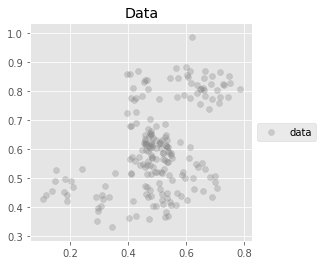

In [4]:
# Load data.
if DATA_SOURCE == 'balog':
    data = np.load(DATA_PATH)
    x = data['X_private']
    mus = data['MUS']
    weights = data['WEIGHTS']
    sigma_data = data['SIGMA_DATA']
    assert (M, DIM) == np.shape(x), 'Balog data dims do not match global params.'
    print('Loaded M={} data points with dimension DIM={}'.format(M, DIM))
    plt.scatter(x[:, 0], x[:, 1], c="gray", alpha=0.3,
                label='data')
    #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
    #            label='true centroids')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Data')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

___

# 3. Run Support Point Optimization


  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0040


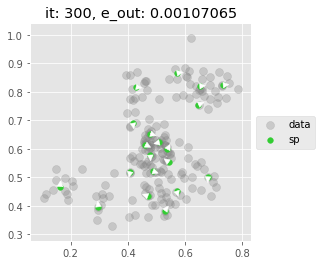

In [5]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

___

# 4. Define sensitivity.

In [6]:
# Define energy sensitivity for Exponential Mechanism.
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2
print(('Laplace(2 * U / alpha) = Laplace(2 * {:.4f} / {:.2f}) '
       '= Laplace({:.3f})').format(energy_sensitivity, ALPHA, 
                                   2. * energy_sensitivity / ALPHA))

Laplace(2 * U / alpha) = Laplace(2 * 0.0071 / 2.00) = Laplace(0.007)


___

# 5. Sample support points.


  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0041


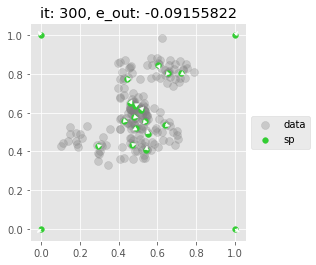


  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0040


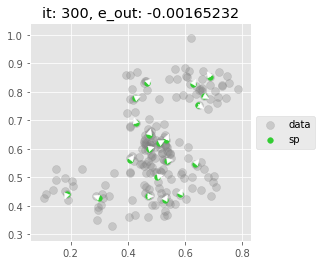


  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0041


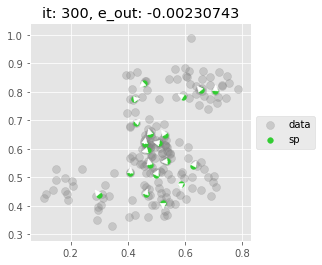


  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0072


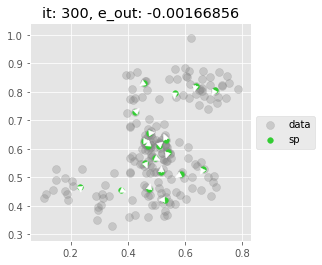


  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0059


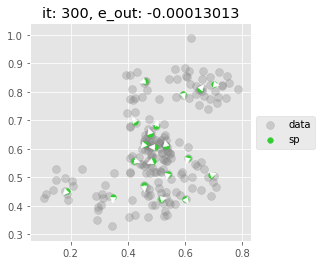


  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0041


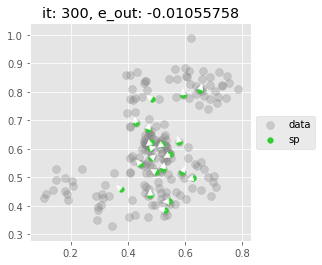


  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0061


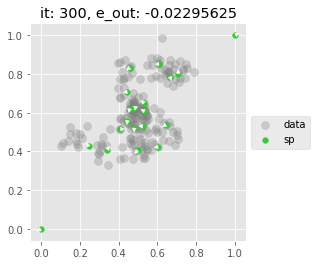


  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0044


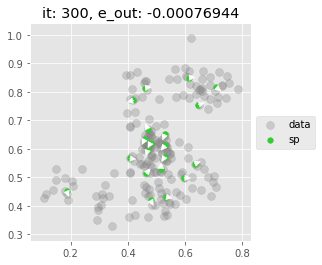


  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0058


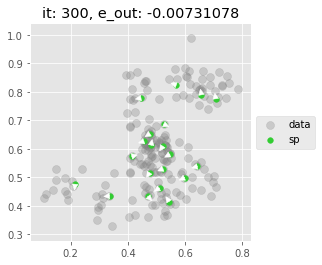


  [*] Using TensorFlow optimization.
  [*] Overall it/s: 0.0048


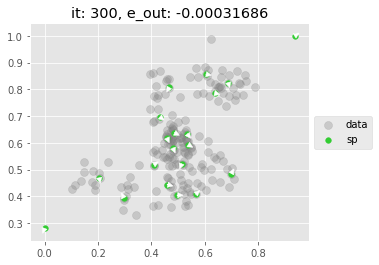

In [7]:
# Sampling parameters.
STEP_SIZE = 1e-3
NUM_Y_TILDES = 1

RUN_MH = 0
RUN_DIFFUSION = 0
RUN_EXPONENTIAL_WEIGHTING = 1
PLOT = 0

if RUN_MH:
    METHOD = 'mh'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_mh,
     energies_mh) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                       METHOD, STEP_SIZE, NUM_Y_TILDES, 
                                       alpha=ALPHA)

if RUN_DIFFUSION:
    METHOD = 'diffusion'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_diffusion,
     energies_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                              METHOD, STEP_SIZE, NUM_Y_TILDES,
                                              alpha=ALPHA)
    
if RUN_EXPONENTIAL_WEIGHTING:
    # Compute N support points from full set x.
    
    num_samples = 10
    y_opt_all = np.zeros((num_samples, N, DIM))
    
    for i in range(num_samples):
        y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF,
                                          do_weights=True)
        y_opt_all[i] = y_opt

    y_all = np.concatenate(y_opt_all, axis=0)
      
        
    """
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')    
    for j, y_ in enumerate(y_opt_all):
        plt.scatter(y_[:, 0], y_[:, 1], alpha=1, label='~sp(data)_{}'.format(j))        
        
    plt.title('{}'.format('exponential weights'))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    # Show marginals.
    y_all = np.concatenate(y_opt_all, axis=0)

    plt.hist(x[:, 0], label='data_p1', density=True, bins=20)
    plt.hist(y_all[:, 0], label='y_all_p1', density=True, bins=20)
    plt.title('Marginal, p1')
    plt.legend()
    plt.show()

    plt.hist(x[:, 1], label='data_p2', density=True, bins=20)
    plt.hist(y_all[:, 1], label='y_all_p2', density=True, bins=20)
    plt.title('Marginal, p2')
    plt.legend()
    plt.show()
    pdb.set_trace()
    """

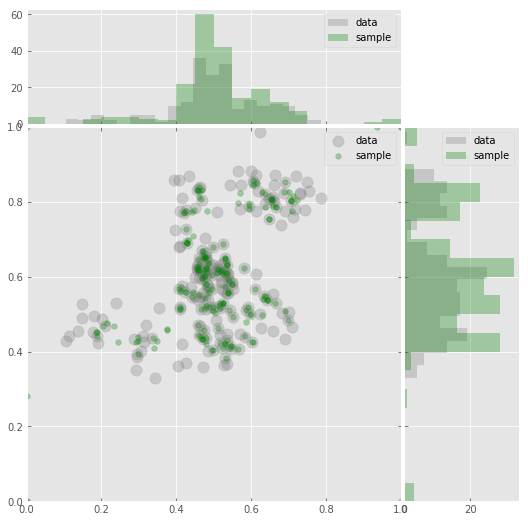

In [8]:
if RUN_EXPONENTIAL_WEIGHTING:
    # Isolate data to plot.
    plot_x1 = x[:, 0]
    plot_x2 = x[:, 1]
    plot_y1 = y_all[:, 0]
    plot_y2 = y_all[:, 1]

    # Definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # Start with a rectangular Figure
    plt.figure(figsize=(8, 8))

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # Make scatter plot:
    ax_scatter.scatter(plot_x1, plot_x2, color='gray', alpha=0.3,
                       label='data', s=128)
    ax_scatter.scatter(plot_y1, plot_y2, color='green', alpha=0.3,
                       label='sample', s=32)
    ax_scatter.set_xlim((0, 1))
    ax_scatter.set_ylim((0, 1))
    ax_scatter.legend()

    # Make histograms.
    ax_histx.hist(plot_x1, bins=20, alpha=0.3, color='gray', label='data')
    ax_histx.hist(plot_y1, bins=20, alpha=0.3, color='green', label='sample')
    ax_histy.hist(plot_x2, bins=20, alpha=0.3, orientation='horizontal',
                  color='gray', label='data')
    ax_histy.hist(plot_y2, bins=20, alpha=0.3, orientation='horizontal',
                  color='green', label='sample')
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    ax_histx.legend()
    ax_histy.legend()

    plt.show()

In [9]:
# Plot results of sampling for private support points.
if PLOT:
    if RUN_MH:
        plt.title('Energies with MH, n={}'.format(len(energies_mh)))
        plt.hist(energies_mh, bins=20, alpha=0.3)
        plt.show()

    if RUN_DIFFUSION:
        plt.title('Energies with Diffusion, n={}'.format(len(energies_diffusion)))
        plt.hist(energies_diffusion, bins=20, alpha=0.3)
        plt.show()

    # Compare to energies of e(y_opt, uniform)
    baseline_energies = np.zeros(NUM_Y_TILDES)
    for i in range(NUM_Y_TILDES):
        e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
        baseline_energies[i] = e_
    plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
    plt.hist(baseline_energies, bins=20, alpha=0.3)
    plt.show()

___

# 6. Expand to full data set.

### 6.0  Given privately sampled (by diffusion) SP, expand them using KDE and pre-selected bandwidth.

In [10]:
# Show data and y_tilde.
if 0:
    NUM_Y_TILDES = 1
    METHOD = 'diffusion'
    BANDWIDTH = 0.055
    SAMPLE_SIZE = M
    STEP_SIZE = 2e-3

    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion,
     energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                      x, y_opt, STEP_SIZE, ALPHA,
                                                      BANDWIDTH, SAMPLE_SIZE)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
                alpha=0.3, label='FULL')

    plt.title('{}, and PRE-SELECTED w = {}'.format(METHOD, BANDWIDTH))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


###  6.1  Show KDE over a range of bandwidths, and compute likelihood for each.

In [11]:
# Find optimal bandwidth using Maximum Likelihood.
if 0:
    NUM_BANDWIDTHS = 1
    BW_HIGH, BW_LOW = 0.01, 0.0001
    BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)
    PLOT = 1

    # Store bandwidth and likelihood pairs.
    bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

    bw_opt_lik = 0
    bw_opt = 1e10
    bw_worst_lik = 1e100
    bw_worst = 0

    # Measure data likelihood under models centered on private support
    # points, with a range of bandwidths.
    for i, bw in enumerate(BW_RANGE):    
        lik, do_log = mixture_model_likelihood(x, y_tilde, bw)

        if lik > bw_opt_lik:
            bw_opt_lik = lik
            bw_opt = bw

        if lik <= bw_worst_lik:
            bw_worst_lik = lik
            bw_worst = bw

        bw_lik[i] = [bw, lik]


    # Print and plot all bandwidth-likelihood pairs.
    max_bw_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]

    for bw, lik in bw_lik:
        print('bw: {:.6f}, lik: {:.2e}'.format(bw, lik))
    plt.plot(bw_lik[:, 0], bw_lik[:, 1])
    plt.scatter(*max_bw_lik, label='max lik')
    plt.xlabel('bandwidth')
    plt.ylabel('log likelihood, log: {}'.format(do_log))
    plt.title('MLE, bw={:.6f}, lik={:.3e}'.format(max_bw_lik[0], max_bw_lik[1]))
    plt.legend()
    plt.show()


    # Compare to likelihoods of data and optimal support points.
    lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_opt)
    lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_opt)

    print('do_log: {}'.format(do_log))
    print('P(x | y_opt, bw_opt): {:.2e}'.format(lik_y_opt))
    print('P(x | y_tilde, bw_opt): {:.2e}'.format(lik_y_tilde))


    # Plot results.
    new_sample = (
        y_tilde_upsampled + np.random.normal(0, bw_opt,
                                             size=(SAMPLE_SIZE, x.shape[1])))
    new_sample_worst = (
        y_tilde_upsampled + np.random.normal(0, bw_worst,
                                             size=(SAMPLE_SIZE, x.shape[1])))


    if PLOT:
        plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
        #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
        #    label='true centroids')
        plt.scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7,
                    label='sp(data)')
        plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                    label='~sp(data)')
        plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3,
                    label='FULL')

        plt.title('BEST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
            'diffusion', bw_opt, bw_opt_lik))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()


        plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
        #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
        #    label='true centroids')
        plt.scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7,
                    label='sp(data)')
        plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                    label='~sp(data)')
        plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                    alpha=0.3, label='FULL')

        plt.title('WORST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
            'diffusion', bw_worst, bw_worst_lik))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

____

### 6.2. Try repeated draws of private support points, and concatenate results.

In [12]:
if 0:
    NUM_REPEATS = int(M / N) + 1
    new_sample = []
    STEP_SIZE = 5e-3

    #print('NOTE: CHANGED ALPHA!')
    #ALPHA = NUM_REPEATS * ALPHA

    for i in range(NUM_REPEATS):
        (y_tilde,
         y_tilde_upsampled,
         y_tilde_expansion,
         energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                          x, y_opt, STEP_SIZE,
                                                          ALPHA / float(NUM_REPEATS),
                                                          BANDWIDTH, SAMPLE_SIZE)
        new_sample.append(y_tilde)

    print('\nConcatenating results, and plotting collection of samples as one.\n')

    new_sample = np.concatenate(new_sample)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    # plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(new_sample[:, 0], new_sample[:, 1], c='red', alpha=0.3, label='FULL')

    plt.title('{}, alpha={:.3f}, repeats={}, n={}, budget={}'.format(
        METHOD, ALPHA / float(NUM_REPEATS), NUM_REPEATS, len(new_sample), ALPHA))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.xlim(0, 1)
    #plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### 6.3 Use DP sample of median of pairwise distances as bandwidth.
Choose W based on data (median heuristics). Add DP noise to W, i.e. add $\eta \sim \mbox{Lap}(2^{(1/p)} / 2)$. Get SP with MMD_W. Do KDE with W.

In [13]:
if 0:
    # Show data and y_tilde.
    NUM_Y_TILDES = 1
    METHOD = 'diffusion'
    SAMPLE_SIZE = M
    STEP_SIZE = 2e-3

    # Compute median of pairwise distanes, and use that as bandwidth.
    median_pairwise_dists = np.median(pdist(x, 'minkowski', p=ENERGY_POWER))
    sensitivity_median_pairwise_dists = DIM ** (1. / ENERGY_POWER) / 2.
    private_median = median_pairwise_dists + np.random.laplace(
        scale=sensitivity_median_pairwise_dists / ALPHA)
    print(median_pairwise_dists)
    print(private_median)
    #pdb.set_trace()

    """
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion,
     energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                      x, y_opt, STEP_SIZE, ALPHA,
                                                      private_median, SAMPLE_SIZE)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
                alpha=0.3, label='FULL')

    plt.title('{}, and PRE-SELECTED w = {}'.format(METHOD, BANDWIDTH))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    """

# End.